In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
import random
from sklearn import model_selection

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from itertools import chain, repeat, cycle


import os
import shutil
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
Using TensorFlow backend.


Setup the directories for feed images, it will be train, and validation directories

In [3]:
DATA_DIR = "../DL3 Dataset"
TRAIN_DIR = DATA_DIR + "/train"
VAL_DIR = DATA_DIR + "/val"

NUM_TRAIN_EXAMPLES = 0
NUM_VAL_EXAMPLES = 0

if not os.path.exists(TRAIN_DIR) or  not os.path.exists(VAL_DIR):
    data = glob.glob(DATA_DIR + "/train_img/*.jpg")
    print("creating data directories for training and validation")
    train, val = model_selection.train_test_split(data, test_size=0.2)
    os.makedirs(TRAIN_DIR)
    os.makedirs(VAL_DIR)

    for e in train:
        shutil.move(e, TRAIN_DIR + "/" + e.split("/")[-1] )
    for e in val:
        shutil.move(e, VAL_DIR + "/" + e.split("/")[-1] )
else:
    print("directories already exist")
    NUM_TRAIN_EXAMPLES = len(glob.glob(TRAIN_DIR+"/*.jpg"))
    print("Train:", NUM_TRAIN_EXAMPLES )
    NUM_VAL_EXAMPLES = len(glob.glob(VAL_DIR+"/*.jpg"))
    print("Validation:",NUM_VAL_EXAMPLES )

directories already exist
Train: 10080
Validation: 2520


### Creating Inception Model


In [15]:
inception_model = InceptionV3(weights='imagenet', include_top=False)

img_width, img_height = 299, 299
batch_size = 32

top_layers_checkpoint_path = 'cp.top.best.hdf5'
fine_tuned_checkpoint_path = 'cp.fine_tuned.best.hdf5'
new_extended_inception_weights = 'final_weights.hdf5'

x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='tanh')(x)
prediction = Dense(85, activation='sigmoid')(x)

model = Model(input=inception_model.input, output=prediction)

if os.path.exists(top_layers_checkpoint_path):
    model.load_weights(top_layers_checkpoint_path)
    print ("Checkpoint '" + top_layers_checkpoint_path + "' loaded.")

"""
Freeze all inception layers
"""
for layer in inception_model.layers:
    layer.trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Checkpoint 'cp.top.best.hdf5' loaded.


In [77]:
train_labels = pd.read_csv(DATA_DIR + '/meta-data/train.csv', index_col='Image_name')

def grouper(n, iterable, padvalue=None):
    g = cycle(zip(*[chain(iterable, repeat(padvalue, n-1))]*n))
    for batch in g:
        yield list(filter(None, batch))
 
 
def multilabel_flow(path_to_data, idg, bs=256, target_size=(32,32), train_or_valid='train', shuffle=False):
    gen = idg.flow_from_directory(path_to_data, batch_size=bs, target_size=target_size, classes=[train_or_valid], shuffle=shuffle)
    names_generator = grouper(bs, gen.filenames)
    for (X_batch, _), names in zip(gen, names_generator):
        labels = [ train_labels.loc[n.split('/')[-1]] for n in names ]
        targets = np.array(labels)
        yield X_batch, targets
 


In [78]:
train_gen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.3,
    channel_shift_range=0.3,
    horizontal_flip=True)

test_gen = image.ImageDataGenerator(rescale=1./255)

train_generator = multilabel_flow(
                    DATA_DIR,
                    train_gen,
                    bs=batch_size,
                    target_size=(img_height, img_width),
                    train_or_valid='train',shuffle=True)

validation_generator = multilabel_flow(
                    DATA_DIR,
                    test_gen,
                    bs=batch_size,
                    target_size=(img_height, img_width),
                    train_or_valid='val', shuffle=True)

Found 10080 images belonging to 1 classes.


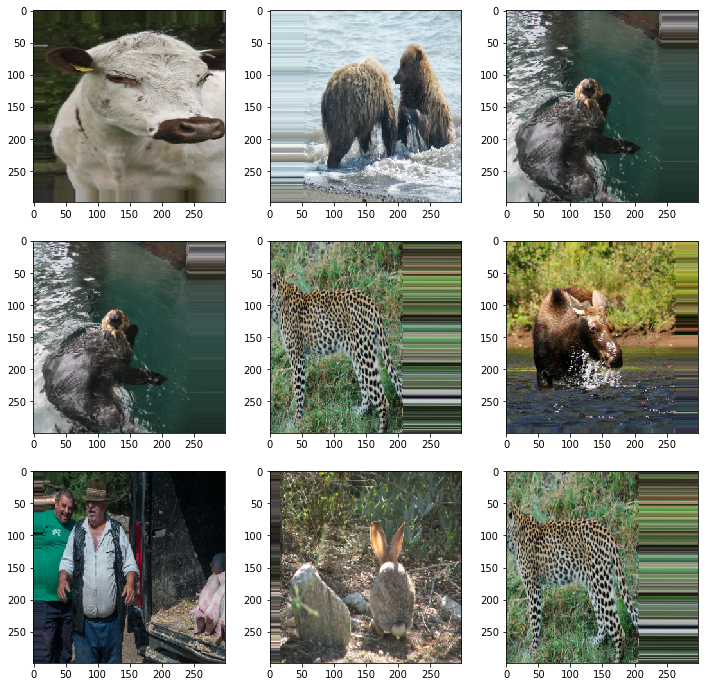

In [10]:
samples = next(train_generator)
fig, draws = plt.subplots(3,3, figsize=(12,12))
draws = draws.reshape(-1)
for i in range(9):
    draws[i].imshow(samples[0][random.randint(0, 23)])

### Training

In [18]:
tb = TensorBoard(log_dir='./logs', write_graph=True)
mc_top = ModelCheckpoint(top_layers_checkpoint_path,
                         monitor='val_acc', verbose=0,
                         save_best_only=True,
                         save_weights_only=False,
                         mode='auto', period=1)
top_epochs = 5

model.fit_generator(train_generator, steps_per_epoch=NUM_TRAIN_EXAMPLES//batch_size,
         nb_epoch=top_epochs, validation_data=validation_generator,
         validation_steps=NUM_VAL_EXAMPLES//batch_size,
         callbacks=[mc_top, tb], use_multiprocessing=True)               

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=315, validation_data=<generator..., validation_steps=78, callbacks=[<keras.ca..., use_multiprocessing=True, epochs=5)`


Epoch 1/5
315/315 [==============================] - 1246s 4s/step - loss: 0.0600 - acc: 0.9771 - val_loss: 0.0770 - val_acc: 0.9727
Epoch 2/5
315/315 [==============================] - 1209s 4s/step - loss: 0.0533 - acc: 0.9797 - val_loss: 0.0855 - val_acc: 0.9707
Epoch 3/5
315/315 [==============================] - 1214s 4s/step - loss: 0.0484 - acc: 0.9816 - val_loss: 0.0789 - val_acc: 0.9730
Epoch 4/5
315/315 [==============================] - 1216s 4s/step - loss: 0.0451 - acc: 0.9829 - val_loss: 0.0750 - val_acc: 0.9745
Epoch 5/5
315/315 [==============================] - 1220s 4s/step - loss: 0.0408 - acc: 0.9848 - val_loss: 0.0774 - val_acc: 0.9736


In [ ]:
mc_fit = ModelCheckpoint(fine_tuned_checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=2)
if os.path.exists(fine_tuned_checkpoint_path):
    inception_model.load_weights(fine_tuned_checkpoint_path)
    print("Checkpoint '" + fine_tuned_checkpoint_path + "' loaded.")

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

model.compile(optimizer=Adam(lr=0.0008), loss='binary_crossentropy', metrics=['accuracy'])

fit_epochs = 3
model.fit_generator(
    train_generator,
    steps_per_epoch=NUM_TRAIN_EXAMPLES // batch_size,
    nb_epoch=fit_epochs,
    validation_data=validation_generator,
    validation_steps=NUM_VAL_EXAMPLES // batch_size,
    callbacks=[mc_fit, tb])

model.save_weights(new_extended_inception_weights)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=315, validation_data=<generator..., validation_steps=78, callbacks=[<keras.ca..., epochs=3)`


Epoch 1/3
315/315 [==============================] - 594s 2s/step - loss: 0.5108 - acc: 0.7434 - val_loss: 0.5133 - val_acc: 0.7359
Epoch 2/3
314/315 [============================>.] - ETA: 1s - loss: 0.5105 - acc: 0.7433

In [29]:
result[0]>=0.5

array([ True, False, False, False, False,  True, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False,  True, False, False, False,  True, False,  True,
        True, False, False,  True, False, False, False, False, False,
       False, False, False,  True,  True, False,  True, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True,  True,  True, False, False,  True,
       False,  True,  True,  True, False,  True, False, False, False,
       False,  True, False, False])

In [125]:
preds = model.predict(X_test)
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

result = preds.reshape(-1) == y_test_.reshape(-1)
acc_on_test = sum(result)/len(result)
print("Accuracy", acc_on_test)

Accuracy 0.976360877684407


### Test images from Hacker Earth

In [127]:
test_images = glob.glob(DATA_DIR + "/test_img/*.jpg")


(85,)

In [67]:
preds = []
for img_ in test_images:
    img = image.load_img(img_, target_size=(img_height, img_width))
    img = image.img_to_array(img) * 1./255
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    preds.append(pred[0])


In [69]:
preds = np.array(preds)

In [70]:
preds[preds>=0.5] = 1
preds[preds<0.5] = 0

In [71]:
attribs = ['attrib_'+"{:02}".format(i) for i in range(1, 86)]

In [72]:
data = {}
for i in range(len(preds)):
    row = {a: int(b)  for (a,b) in zip(attribs, preds[i])}
    image_name = test_images[i].split("/")[-1]
    data[image_name] = row

In [73]:
result = []
for val in test_labels['Image_name'].tolist():
    point_ = data[val]
    point_['Image_name'] = val
    result.append(point_)
    

In [74]:
df_preds = pd.DataFrame(result)
df_preds = df_preds.set_index('Image_name')

In [75]:
df_preds.head()

,attrib_01,attrib_02,attrib_03,attrib_04,attrib_05,attrib_06,attrib_07,attrib_08,attrib_09,attrib_10,...,attrib_76,attrib_77,attrib_78,attrib_79,attrib_80,attrib_81,attrib_82,attrib_83,attrib_84,attrib_85
Image_name,,,,,,,,,,,,,,,,,,,,,
Image-1.jpg,0,0,0,0,0,1,0,0,1,1,...,0,0,0,1,1,0,0,1,0,1
Image-2.jpg,0,0,0,1,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,1,1
Image-3.jpg,0,0,0,1,0,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,1
Image-4.jpg,1,0,0,1,0,1,1,0,0,1,...,0,1,1,0,0,0,0,0,0,1
Image-5.jpg,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,1,0,0,1,0,0


In [76]:
df_preds.to_csv('result.csv')